In [1]:
import pandas as pd
import numpy as np
import json
import functions
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sodapy import Socrata

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
creds_file = open('./creds.json', 'r')
socrata_creds = json.loads(creds_file.read())

In [5]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", socrata_creds['app_token'])

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# Data
---

### DHS Daily Report
Source: https://data.cityofnewyork.us/Social-Services/DHS-Daily-Report/k46n-sa2m

This dataset includes the daily number of families and individuals residing in the Department of Homeless Services (DHS) shelter system and the daily number of families applying to the DHS shelter system.

In [6]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("k46n-sa2m", limit = 10_000);

# Convert to pandas DataFrame
daily_df = pd.DataFrame.from_records(results);

# Data Cleaning

The type of all columns is 'object'. `date_of_census` is datetime column and rest of the columns are numerical column. Change the types appropriately.

In [7]:
daily_df['date_of_census'] = daily_df['date_of_census'].apply(lambda x: x.split('T')[0])

daily_df.index = pd.to_datetime(daily_df['date_of_census'], format = "%Y/%m/%d")
daily_df = daily_df.drop('date_of_census', axis = 1)

daily_df = daily_df.apply(pd.to_numeric)

daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2230 entries, 2019-11-30 to 2013-08-21
Data columns (total 12 columns):
total_adults_in_shelter                                    2230 non-null int64
total_children_in_shelter                                  2230 non-null int64
total_individuals_in_shelter                               2230 non-null int64
single_adult_men_in_shelter                                2230 non-null int64
single_adult_women_in_shelter                              2230 non-null int64
total_single_adults_in_shelter                             2230 non-null int64
families_with_children_in_shelter                          2230 non-null int64
adults_in_families_with_children_in_shelter                2230 non-null int64
children_in_families_with_children_in_shelter              2230 non-null int64
total_individuals_in_families_with_children_in_shelter_    2230 non-null int64
adult_families_in_shelter                                  2230 non-null int64
indivi

In [8]:
weekly_df = daily_df.resample('W').mean()

In [9]:
train, test = train_test_split(weekly_df['total_individuals_in_shelter'],
                               test_size = 0.25,
                               shuffle = False,
                               random_state = 274)

In [10]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in [3, 4, 51, 52]: 
                # testing monthly seasonality with 3,4
                # testing yearly seaonailty with 51, 52
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,1,0)x(0,0,0,3)
The MSE for (0, 1, 0)x(0,0,0,3) is: 1101378.8062468877
Attempting to fit SARIMAX(0,1,0)x(0,0,0,4)
The MSE for (0, 1, 0)x(0,0,0,4) is: 1101378.8062468877
Attempting to fit SARIMAX(0,1,0)x(0,0,0,51)
The MSE for (0, 1, 0)x(0,0,0,51) is: 1101378.8062468877
Attempting to fit SARIMAX(0,1,0)x(0,0,0,52)
The MSE for (0, 1, 0)x(0,0,0,52) is: 1101378.8062468877
Attempting to fit SARIMAX(0,1,0)x(0,1,0,3)
The MSE for (0, 1, 0)x(0,1,0,3) is: 57945837.87568285
Attempting to fit SARIMAX(0,1,0)x(0,1,0,4)
The MSE for (0, 1, 0)x(0,1,0,4) is: 29603162.388017066
Attempting to fit SARIMAX(0,1,0)x(0,1,0,51)
The MSE for (0, 1, 0)x(0,1,0,51) is: 1158393.4175030447
Attempting to fit SARIMAX(0,1,0)x(0,1,0,52)
The MSE for (0, 1, 0)x(0,1,0,52) is: 1116041.587096818
Attempting to fit SARIMAX(0,1,0)x(0,2,0,3)
The MSE for (0, 1, 0)x(0,2,0,3) is: 19326338.230407484
Attempting to fit SARIMAX(0,1,0)x(0,2,0,4)
The MSE for (0, 1, 0)x(0,2,0,4) is: 146361963.69345078
Attempting to 

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,1,1,51) is: 1895991.4374177312
Attempting to fit SARIMAX(0,1,0)x(0,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,1,1,52) is: 1838327.5797942404
Attempting to fit SARIMAX(0,1,0)x(0,2,1,3)
The MSE for (0, 1, 0)x(0,2,1,3) is: 206484899.0921563
Attempting to fit SARIMAX(0,1,0)x(0,2,1,4)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(0,2,1,4) is: 100881733.71582998
Attempting to fit SARIMAX(0,1,0)x(0,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,3)
The MSE for (0, 1, 0)x(0,0,2,3) is: 1173012.2886936297
Attempting to fit SARIMAX(0,1,0)x(0,0,2,4)
The MSE for (0, 1, 0)x(0,0,2,4) is: 1231351.5684557087
Attempting to fit SARIMAX(0,1,0)x(0,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,3)
The MSE for (0, 1, 0)x(0,1,2,3) is: 22055111.28768853
Attempting to fit SARIMAX(0,1,0)x(0,1,2,4)
The MSE for (0, 1, 0)x(0,1,2,4) is: 16917936.330376096
Attempting to fit SARIMAX(0,1,0)x(0,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,3)
The MSE for (0, 1, 0)x(0,2,2,3) is: 114063674.09124553
Attempting to fit SARIMAX(0,1,0)x(0,2,2,4)
The MSE for (0, 1, 0)x(0,2,2,4) is: 86452984.91461307
Attempting to fit SARIMAX(0,1,0)x(0,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(0,2,2,52)
Attempt

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,1,1,51) is: 2374861.245195787
Attempting to fit SARIMAX(0,1,0)x(1,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,1,1,52) is: 1456521.7204501089
Attempting to fit SARIMAX(0,1,0)x(1,2,1,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,2,1,3) is: 174850667.97058383
Attempting to fit SARIMAX(0,1,0)x(1,2,1,4)
The MSE for (0, 1, 0)x(1,2,1,4) is: 93660112.09250768
Attempting to fit SARIMAX(0,1,0)x(1,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,3)
The MSE for (0, 1, 0)x(1,0,2,3) is: 1739164.119471206
Attempting to fit SARIMAX(0,1,0)x(1,0,2,4)
The MSE for (0, 1, 0)x(1,0,2,4) is: 1565138.379131277
Attempting to fit SARIMAX(0,1,0)x(1,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,3)
The MSE for (0, 1, 0)x(1,1,2,3) is: 25500359.26246388
Attempting to fit SARIMAX(0,1,0)x(1,1,2,4)
The MSE for (0, 1, 0)x(1,1,2,4) is: 1791104.6001882236
Attempting to fit SARIMAX(0,1,0)x(1,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(1,2,2,3) is: 207985918.74359348
Attempting to fit SARIMAX(0,1,0)x(1,2,2,4)
The MSE for (0, 1, 0)x(1,2,2,4) is: 22011953.65816344
Attempting to fit SARIMAX(0,1,0)x(1,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(1,2,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,0,0,3)
The MSE for (0, 1, 0)x(2,0,0,3) is: 1292621.5505465465
Attempting to fit SARIMAX(0,1,0)x(2,0,0,4)
The MSE for (0, 1, 0)x(2,0,0,4) is: 1471576.9117924473
Attempting to fit SARIMAX(0,1,0)x(2,0,0,51)
The MSE for (0, 1, 0)x(2,0,0,51) is: 775785.9400971436
Attempting to fit SARIMAX(0,1,0)x(2,0,0,52)
The MSE for (0, 1, 0)x(2,0,0,52) is: 596475.1894623172
Attempting to fit SARIMAX(0,1,0)x(2,1,0,3)
The MSE for (0, 1, 0)x(2,1,0,3) is: 44499443.243879125
Attempting to fit SARIMAX(0,1,0)x(2,1,0,4)
The MSE for (0, 1, 0)x(2,1,0,4) is: 36866862.68175104
Attempting to fit SARIMAX(0,1,0)x(2,1,0,51)
The MSE for (0, 1, 0)x(2,1,0,51) is: 1536289.7863622177
Attempting to fit SARIMAX(0,1,0)x(2,1,0,52)
The MSE for (0, 1, 0)x(2,1,

/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (0, 1, 0)x(2,0,1,52) is: 826962.5864283886
Attempting to fit SARIMAX(0,1,0)x(2,1,1,3)
The MSE for (0, 1, 0)x(2,1,1,3) is: 41724464.59496148
Attempting to fit SARIMAX(0,1,0)x(2,1,1,4)
The MSE for (0, 1, 0)x(2,1,1,4) is: 1708903.496361439
Attempting to fit SARIMAX(0,1,0)x(2,1,1,51)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(2,1,1,51) is: 3611892.763574151
Attempting to fit SARIMAX(0,1,0)x(2,1,1,52)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The MSE for (0, 1, 0)x(2,1,1,52) is: 2422325.4070810555
Attempting to fit SARIMAX(0,1,0)x(2,2,1,3)
The MSE for (0, 1, 0)x(2,2,1,3) is: 116625142.88481562
Attempting to fit SARIMAX(0,1,0)x(2,2,1,4)
The MSE for (0, 1, 0)x(2,2,1,4) is: 90669240.9276651
Attempting to fit SARIMAX(0,1,0)x(2,2,1,51)
Attempting to fit SARIMAX(0,1,0)x(2,2,1,52)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,3)


/Users/dae/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (0, 1, 0)x(2,0,2,3) is: 443213.5202293674
Attempting to fit SARIMAX(0,1,0)x(2,0,2,4)
The MSE for (0, 1, 0)x(2,0,2,4) is: 370275.9125668167
Attempting to fit SARIMAX(0,1,0)x(2,0,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,0,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,3)
The MSE for (0, 1, 0)x(2,1,2,3) is: 50892100.89294389
Attempting to fit SARIMAX(0,1,0)x(2,1,2,4)
The MSE for (0, 1, 0)x(2,1,2,4) is: 1767080.0571379391
Attempting to fit SARIMAX(0,1,0)x(2,1,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,1,2,52)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,3)
The MSE for (0, 1, 0)x(2,2,2,3) is: 108337352.2769095
Attempting to fit SARIMAX(0,1,0)x(2,2,2,4)
The MSE for (0, 1, 0)x(2,2,2,4) is: 24227794.61892028
Attempting to fit SARIMAX(0,1,0)x(2,2,2,51)
Attempting to fit SARIMAX(0,1,0)x(2,2,2,52)
Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x(2,2,0,51).
This model has an MSE of 314274.98661334784.


522193.57866795635


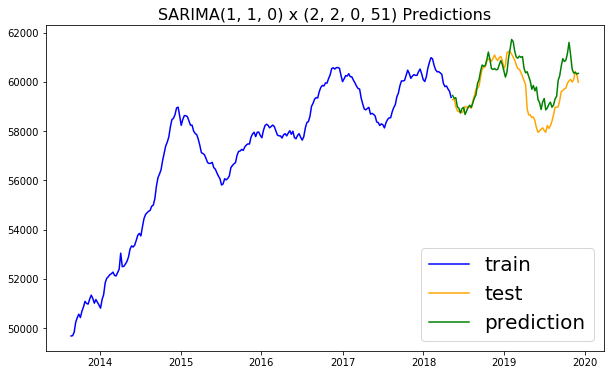

In [11]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 51) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (2, 2, 0, 52) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 51) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

In [12]:
resids = list(test - preds)

In [13]:
evaluate(test, resids)

NameError: name 'evaluate' is not defined

# SARIMAX

In [ ]:
housing_df = pd.read_csv("./homeless/nyc_housing_112019.csv")

In [ ]:
# turn housing_df into timesereis data
housing_df.index = pd.to_datetime(housing_df['project_start_date'], format = "%Y/%m/%d")

In [ ]:
housing_df = housing_df.drop("project_start_date", axis = 1)

In [ ]:
housing_df.shape

- `reporting_construction_type`: Preserve counts might be important?
- `extended_affordability_status`: The Extended Affordability Only field indicates whether the project is considered to be Extended Affordability. An extended affordability project involves no construction, but secures an extended or new regulatory agreement. All extended affordability projects have a ‘reporting construction type’ of ‘preservation.’
- `extremely_low_income_units`: Extremely Low Income Units are units with rents that are affordable to households earning 0 to 30% of the area median income (AMI).
- `very_low_income_units`: Very Low Income Units are units with rents that are affordable to households earning 31 to 50% of the area median income (AMI).
- `low_income_units`: Low Income Units are units with rents that are affordable to households earning 51 to 80% of the area median income (AMI).
- `moderate_income_units`: Moderate Income Units are units with rents that are affordable to households earning 81 to 120% of the area median income (AMI).
- `middle_income_units`: Middle Income Units are units with rents that are affordable to households earning 121 to 165% of the area median income (AMI).
- `all_counted_units`: The Counted Units field indicates the total number of affordable, regulated units counted towards the Housing New York plan that are in the building.
- `total_units`: The Total Units field indicates the total number of units, affordable and market rate, in each building.

In [ ]:
# turn housing_df into weekly times series data
w_housing = housing_df.resample('W').mean()

In [ ]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None):
    
    """
    from lecture 9.02"""
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label = str(col))
#         plt.title(str(col), fontsize=26)
        
    # Generate title and labels.
    
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);
    plt.legend()

In [ ]:
n = range(len(w_housing.columns))

plot_series(w_housing , cols = w_housing.columns[n])

In [ ]:
plot_series(w_housing , cols = ['all_counted_units'])

- It seems like peaks appear in simliar places. `all_counted_units` however seems to have the biggest peaks. Therefore, `all_counted_units` column will be tested in SARIMAX model

In [ ]:
daily_housing = housing_df.resample('D').sum()

In [ ]:
daily_comb = daily_df.join(daily_housing)

### Using all housing data by turning unavailable data = 0

In [ ]:
weekly_comb = daily_comb.resample('W').mean().fillna(0)

In [ ]:
weekly_comb

In [ ]:
plot_series(weekly_comb , cols = ['total_individuals_in_shelter'])

In [ ]:
plot_series(weekly_comb , cols = ['all_counted_units'])

In [ ]:
train, test = train_test_split(weekly_comb[['total_individuals_in_shelter', 'all_counted_units']],
                               test_size = 0.25,
                               shuffle = False,
                               random_state = 274)

In [ ]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 52) model.

sarima = SARIMAX(endog = train.iloc[:,0],
                 exog = train.iloc[:,1], 
                 order = (0, 1, 0),
                 seasonal_order = (2, 2, 0, 52)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1],
                      exog = test.iloc[:,[1]])

In [ ]:
# Evaluate predictions.
print(mean_squared_error(test.iloc[:,0], preds))
print(np.sqrt(mean_squared_error(test.iloc[:,0], preds)))
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train.iloc[:,0], color = 'blue', label = 'train')
plt.plot(test.iloc[:,0], color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 52) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

### Not using unavailable housing data

In [ ]:
daily_comb = daily_housing.join(daily_df)

In [ ]:
weekly_comb = daily_comb.resample('W').mean()

In [ ]:
weekly_comb.to_csv('./homeless/weekly_comb.csv')

In [ ]:
train, test = train_test_split(weekly_comb[['total_individuals_in_shelter', 'all_counted_units']],
                               test_size = 0.25,
                               shuffle = False,
                               random_state = 274)

In [ ]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 52) model.

sarima = SARIMAX(endog = train.iloc[:,0],
                 exog = train.iloc[:,1], 
                 order = (0, 1, 0),
                 seasonal_order = (2, 2, 0, 51)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1],
                      exog = test.iloc[:,[1]])

In [ ]:
# Evaluate predictions.
print(mean_squared_error(test.iloc[:,0], preds))
print(np.sqrt(mean_squared_error(test.iloc[:,0], preds)))
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train.iloc[:,0], color = 'blue', label = 'train')
plt.plot(test.iloc[:,0], color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 51) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();